In [102]:
import os
import cv2
import numpy as np
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
from math import ceil 

In [2]:
tf.__version__

'2.3.0'

In [3]:
unique = np.array(['Mask', 'NoMask'])

In [4]:
model = tf.keras.models.load_model('Model/face-mask.pb')

In [5]:
# model = tf.keras.models.load_model('face-mask.h5',
#                                     custom_objects = {'KerasLayer' : hub.KerasLayer})

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2004      
Total params: 5,434,717
Trainable params: 5,390,461
Non-trainable params: 44,256
_________________________________________________________________


In [10]:
net = cv2.dnn.readNetFromCaffe('deploy.prototxt','weights.caffemodel')

In [98]:
def process_image(frame):
#     temp = detector.detect_faces(frame)
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))   
    net.setInput(blob)
    detections = net.forward()
#     print(detections.shape)
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if (confidence > 0.75):
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1,y1,x2,y2) = box.astype("int")
#             print(x2-x1)
            face = frame[y1:y2, x1:x2]
            face = np.expand_dims(face, axis = 0)
            face1 = tf.constant(face[0])
            face1 = tf.image.convert_image_dtype(face1, dtype = tf.float32)
            face1 = tf.image.resize(face1, (224,224))
            face1 = np.expand_dims(face1, axis = 0)
            face1 = tf.data.Dataset.from_tensor_slices(face1)
            face1 = face1.batch(1)
            pred = model.predict(face1)
#             print(pred)
            ans = unique[np.argmax(pred)]
            font = cv2.FONT_HERSHEY_SIMPLEX
            if ans == 'Mask':
                pred1 = str("{:.2f}".format((pred.max()*100)))
                ans = unique[np.argmax(pred)] + ' ' + pred1 + '%'
                color = (0,255,0)
            else:
                pred1 = str("{:.2f}".format((pred.max()*100)))
                ans = unique[np.argmax(pred)] + ' ' + pred1 + '%'
                color = (0,0,255)
            size1 = (x2-x1) * 3 / 500
            size2 = ceil((x2-x1) * 3 / 700)
            cv2.rectangle(frame, (x1,y1), (x2,y2), color = color, thickness = size2)
            cv2.putText(frame, ans, org = (x1, y1), fontFace=font, fontScale= size1, color=color, thickness=size2)
    return frame

In [99]:
frame = plt.imread('IMG_7408.jpg')

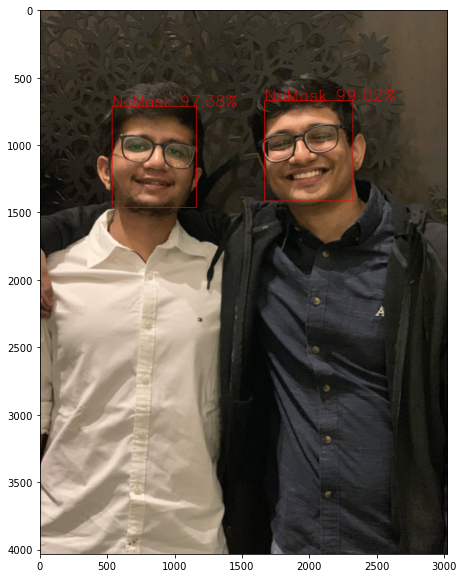

In [100]:
plt.figure(figsize = (10,10))
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
frame = process_image(frame)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

In [101]:
vid = cv2.VideoCapture(0)
while True:
    res, frame = vid.read()
    try:
        if res == True:
            frame = process_image(frame)
            cv2.imshow('test', frame)
    except Exception as e:
        print(e)
        
    if cv2.waitKey(1) == 27:
        break

vid.release()
cv2.destroyAllWindows()

In [127]:
vid.release()